In [1]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=35e4fe6077d3f83c0fb6b31158f66b5028bbe0fa47e42b32c6a82cdf348e3911
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import ta

In [3]:
class StockPlotter:
    def __init__(self, individual_dataframes):
        self.individual_dataframes = individual_dataframes

    def plot_rsi(self):
        plt.figure(figsize=(10, 6))
        for stock_symbol, df in self.individual_dataframes.items():
            plt.plot(df.index, df['RSI'], label=f'RSI ({stock_symbol})', color='red')
        plt.title('Relative Strength Index (RSI)')
        plt.xlabel('Date')
        plt.ylabel('RSI')
        plt.legend()
        plt.show()

    def plot_macd(self):
        plt.figure(figsize=(10, 6))
        for stock_symbol, df in self.individual_dataframes.items():
            plt.plot(df.index, df['MACD'], label=f'MACD ({stock_symbol})', color='green')
        plt.title('Moving Average Convergence Divergence (MACD)')
        plt.xlabel('Date')
        plt.ylabel('MACD')
        plt.legend()
        plt.show()

    def plot_stochastic(self):
        plt.figure(figsize=(10, 6))
        for stock_symbol, df in self.individual_dataframes.items():
            plt.plot(df.index, df['Stochastic'], label=f'Stochastic ({stock_symbol})', color='orange')
        plt.title('Stochastic Oscillator')
        plt.xlabel('Date')
        plt.ylabel('Stochastic')
        plt.legend()
        plt.show()

    def plot_bollinger_bands(self):
        plt.figure(figsize=(10, 6))
        for stock_symbol, df in self.individual_dataframes.items():
            plt.plot(df.index, df['SMA'], label=f'SMA ({stock_symbol})', color='blue')
            plt.plot(df.index, df['Upper Bollinger Band'], label=f'Upper Band ({stock_symbol})', color='green', linestyle='--')
            plt.plot(df.index, df['Lower Bollinger Band'], label=f'Lower Band ({stock_symbol})', color='red', linestyle='--')
        plt.title('Bollinger Bands')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

In [4]:
class StockDataDownloader:
    stock_data_dict = {}
    def __init__(self, stocks, start_date, end_date):
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date

    def download_stock_data(self):
        for stock_symbol in self.stocks:
            stock_data = yf.download(stock_symbol, start=self.start_date, end=self.end_date, interval='1d')
            self.stock_data_dict[stock_symbol] = stock_data

In [ ]:
# Define portfolio details
portfolio_stocks = ['AAPL', 'GOOGL', 'MSFT']
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2020, 4, 4)

# Download stock data
data_downloader = StockDataDownloader(portfolio_stocks, start_date, end_date)
data_downloader.download_stock_data()

# Compute features
feature_calculator = FeatureCalculator(data_downloader.stock_data_dict)
feature_calculator.compute_features()

# Print the features DataFrame for the first stock in the portfolio
#print(feature_calculator.features_dict[portfolio_stocks[1]])

[*********************100%%**********************]  1 of 1 completed

Time Series Analysis

In [6]:
from statsmodels.tsa.stattools import adfuller

class Stationary:
    def __init__(self, data_downloader, portfolio_stocks):
        self.data_downloader = data_downloader
        self.portfolio_stocks = portfolio_stocks
        self.adf_results = {}

    def adf_test(self):
        for stock_symbol in self.portfolio_stocks:
            # Retrieve the closing prices of the current stock
            stock_data = self.data_downloader.stock_data_dict[stock_symbol]
            closing_prices = stock_data['Close']

            # Perform the ADF test
            stat_test = adfuller(closing_prices)

            # Store the ADF test results in the dictionary
            self.adf_results[stock_symbol] = {'Test Statistic': stat_test[0], 'p-value': stat_test[1]}

    def print_results(self):
        for stock_symbol, result in self.adf_results.items():
            print(f"Stock: {stock_symbol}")
            print(f"Test Statistic: {result['Test Statistic']}")
            print(f"p-value: {result['p-value']}")
            print()


In [7]:
# Initialize Stationary object
stationary_tester = Stationary(data_downloader, portfolio_stocks)

# Perform ADF test
stationary_tester.adf_test()

# Print ADF test results
stationary_tester.print_results()

Stock: AAPL
Test Statistic: -0.8357079033232941
p-value: 0.808407511595721

Stock: GOOGL
Test Statistic: -0.8071457935423579
p-value: 0.8170140277383182

Stock: MSFT
Test Statistic: 2.6565752751243474
p-value: 0.9990834889428644



In [8]:
import pandas as pd
from statsmodels.tsa.stattools import acf

class TimeSeriesAnalyzer:
    analyzed_data_dict = {}  # Global dictionary to store analyzed time series data
    features_dict = {}            # Global dictionary to store computed autocorrelation functions

    def __init__(self, stock_data_dict, lags=5, acf_lags=20,window_size=10, alpha=0.2):
        self.stock_data_dict = stock_data_dict
        self.lags = lags
        self.window_size = window_size
        self.alpha = alpha
        self.acf_lags = acf_lags

    def compute_lagged_variables(self, data):
        for i in range(1, self.lags + 1):
            data[f'Lag_{i}'] = data['High'].shift(i)
        return data

    def compute_moving_average(self, data):
        data['Moving_Average'] = data['Volume'].rolling(window=self.window_size).mean()
        return data

    def compute_exponential_smoothing(self, data):
        data['Exponential_Smoothing'] = data['Volume'].ewm(alpha=self.alpha).mean()
        return data

    def compute_autocorrelation_function(self, data):
        acf_values = acf(data['Volume'], nlags=self.acf_lags)
        return acf_values

    def compute_sma(self, data, window=10):
        return data.rolling(window=window).mean()

    def compute_rsi(self, data, window=14):
        return ta.momentum.rsi(data, window=window)

    def compute_macd(self, data):
        return ta.trend.macd_diff(data)

    def compute_stochastic(self, data):
        return ta.momentum.stoch(data, data, data)

    def compute_bollinger_bands(self, data, window=10):
        sma = data.rolling(window=window).mean()
        std = data.rolling(window=window).std()
        upper_band = sma + 2 * std
        lower_band = sma - 2 * std
        return upper_band, sma, lower_band

    def analyze_time_series(self):
        for stock_symbol, stock_df in self.stock_data_dict.items():
            analyzed_data = pd.DataFrame(index=stock_df.index)
            analyzed_data = self.compute_lagged_variables(stock_df)
            analyzed_data = self.compute_moving_average(stock_df)
            analyzed_data = self.compute_exponential_smoothing(stock_df)
            acf_values = self.compute_autocorrelation_function(stock_df)
            analyzed_data['SMA'] = self.compute_sma(stock_df['Volume'])
            analyzed_data['RSI'] = self.compute_rsi(stock_df['Volume'])
            analyzed_data['MACD'] = self.compute_macd(stock_df['Volume'])
            analyzed_data['Stochastic'] = self.compute_stochastic(stock_df['Volume'])
            upper_band, sma, lower_band = self.compute_bollinger_bands(stock_df['Volume'])
            analyzed_data['Upper Bollinger Band'] = upper_band
            analyzed_data['Middle Bollinger Band'] = sma
            analyzed_data['Lower Bollinger Band'] = lower_band
            self.analyzed_data_dict[stock_symbol] = {'Data': analyzed_data, 'Autocorrelation': acf_values}



In [9]:
# Create an instance of TimeSeriesAnalyzer and pass the global stock_data_dict
analyzer = TimeSeriesAnalyzer(StockDataDownloader.stock_data_dict)

# Analyze the time series data
analyzer.analyze_time_series()


Correlation matrix for AAPL:


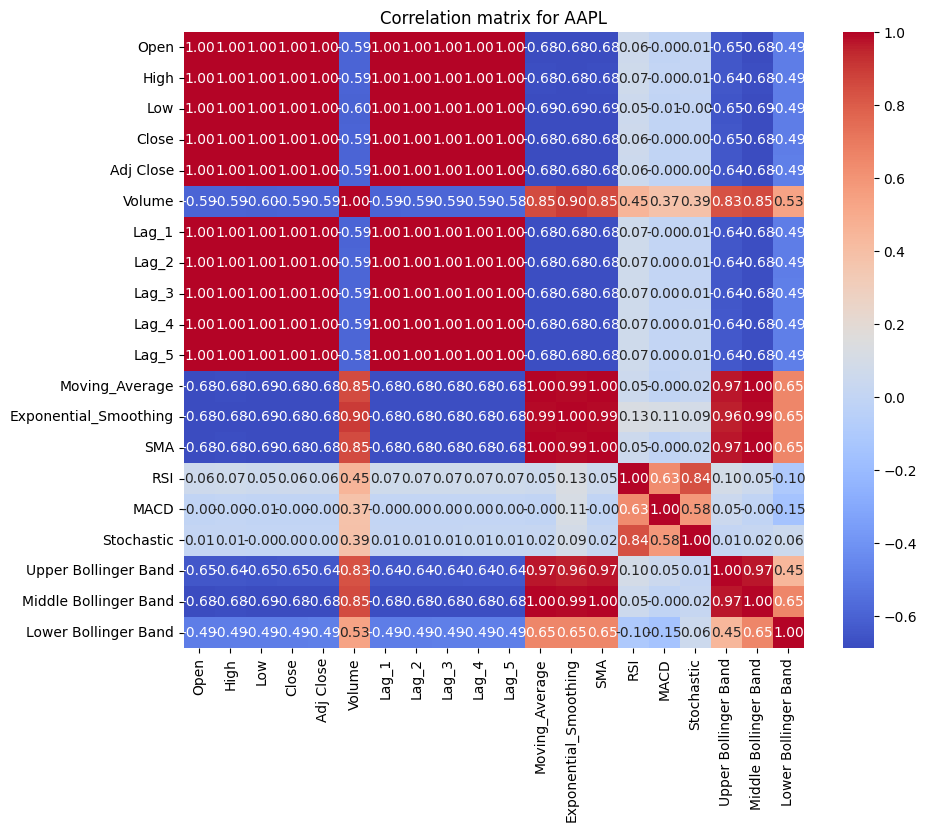


Correlation matrix for GOOGL:


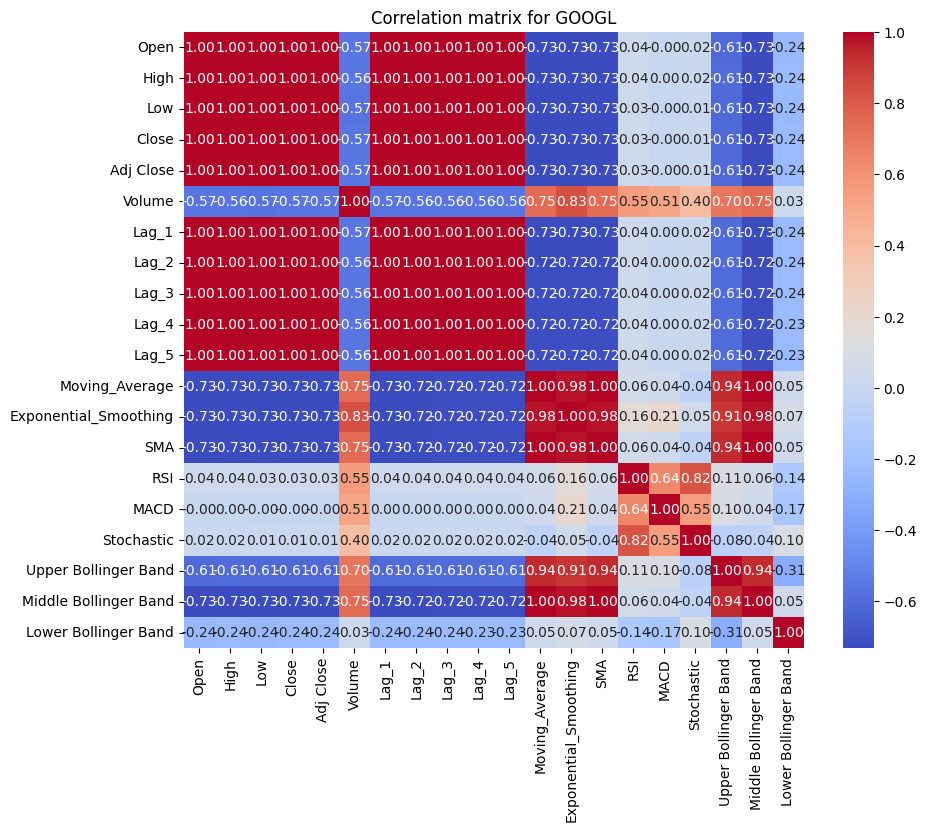


Correlation matrix for MSFT:


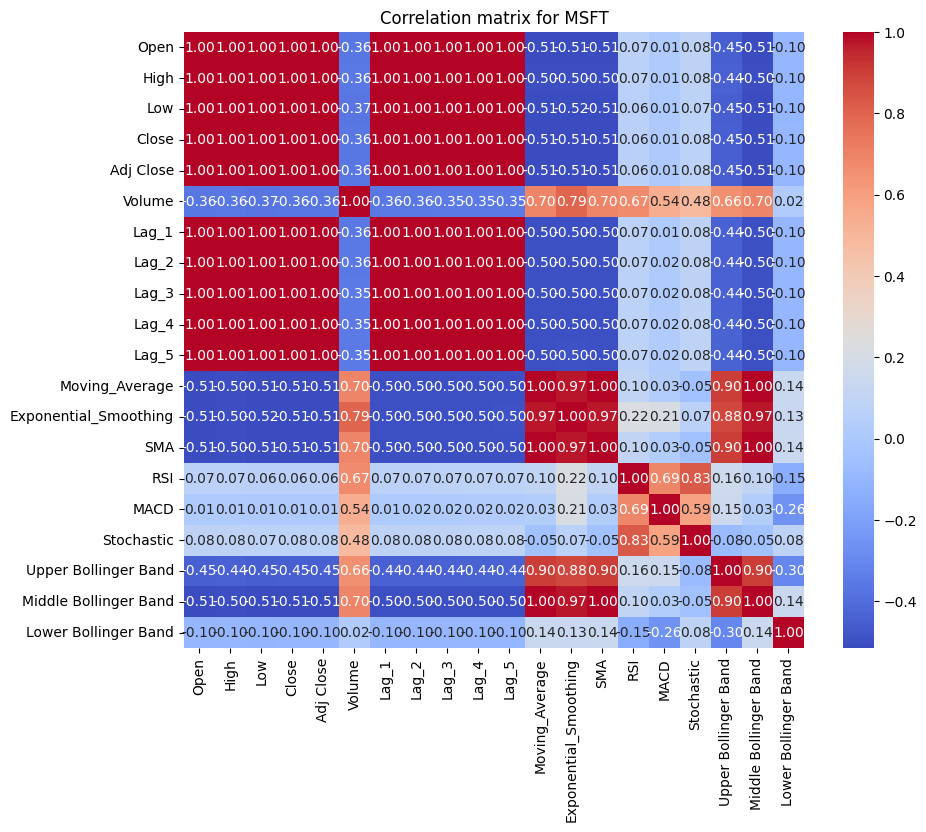

In [10]:
individual_dataframes = {}

for stock_symbol, data_dict in TimeSeriesAnalyzer.analyzed_data_dict.items():
    individual_dataframes[stock_symbol] = data_dict['Data']

for stock_symbol, df in individual_dataframes.items():
    # Check for null values
    #null_values = df.isnull().sum()
    df.dropna(inplace=True)
    null_values = df.isnull().sum()
    #print(f"Null values for {stock_symbol}:")
    #print(null_values)

    # Perform correlation analysis
    correlation_matrix = df.corr()
    print(f"\nCorrelation matrix for {stock_symbol}:")
    #print(correlation_matrix)

    # You can also visualize the correlation matrix if needed
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"Correlation matrix for {stock_symbol}")
    plt.show()


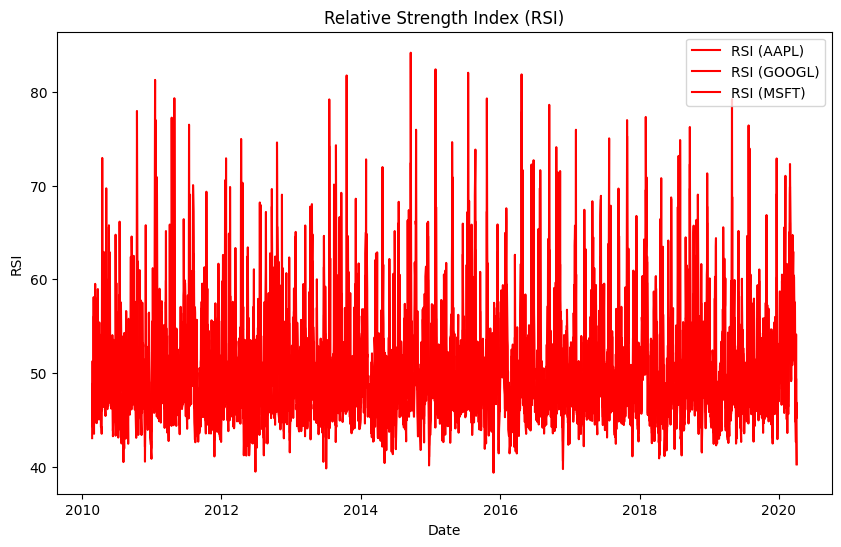

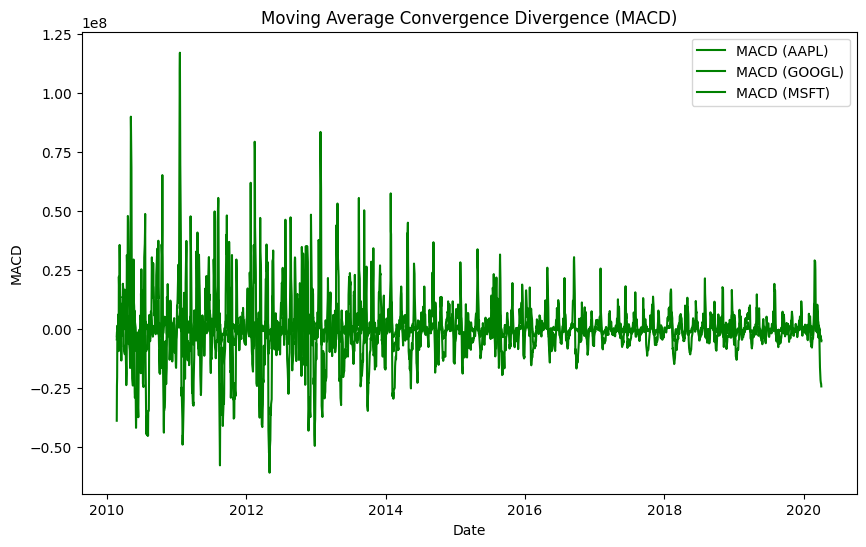

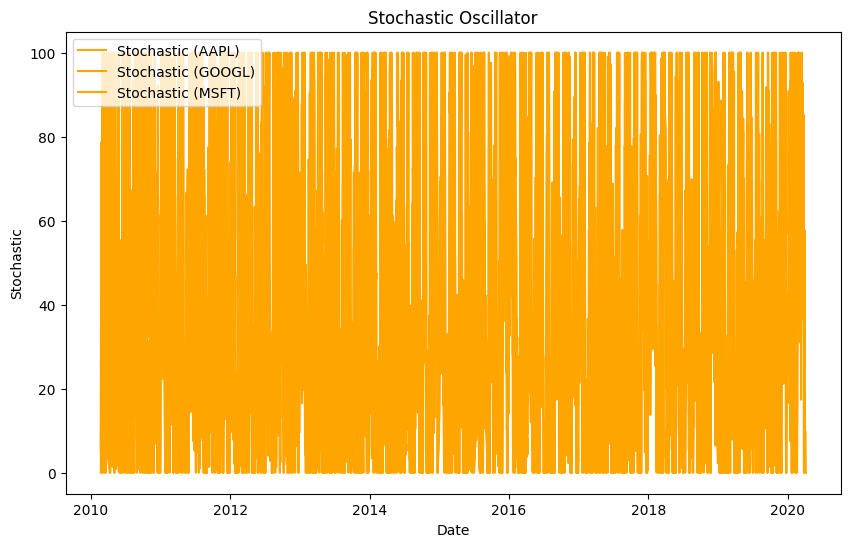

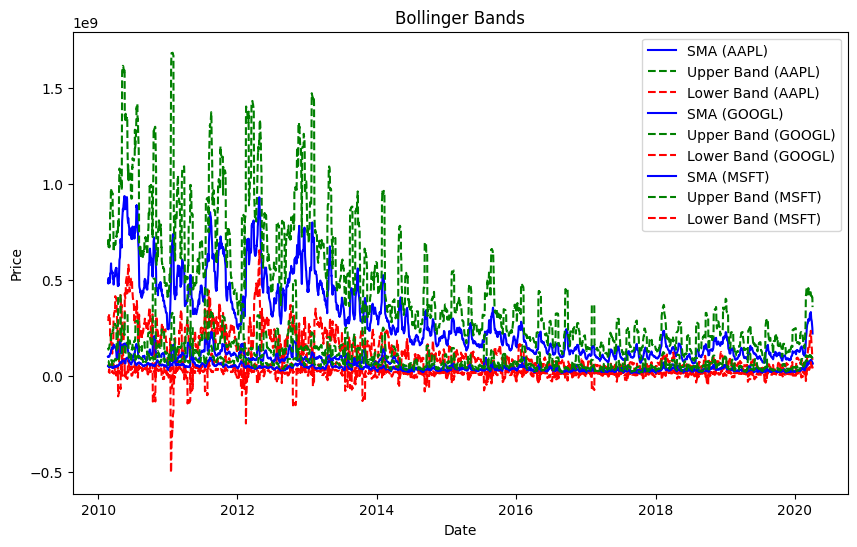

In [11]:
# Create an instance of StockPlotter
stock_plotter = StockPlotter(individual_dataframes)

# Plot the Relative Strength Index (RSI)
stock_plotter.plot_rsi()

# Plot the Moving Average Convergence Divergence (MACD)
stock_plotter.plot_macd()

# Plot the Stochastic Oscillator
stock_plotter.plot_stochastic()

# Plot the Bollinger Bands
stock_plotter.plot_bollinger_bands()

In [12]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Assuming individual_dataframes is a dictionary containing DataFrames for each stock symbol

# Create an empty dictionary to store selected features for each stock symbol
selected_features = {}

# Define the number of features to select
num_features_to_select = 10

# Iterate over individual DataFrames
for stock_symbol, df in individual_dataframes.items():
    # Separate features and target variable
    X = df.drop(columns=['Close'])  # Assuming 'target_column' is the target variable
    y = df['Close']

    # Initialize RandomForestClassifier
    rf_classifier = RandomForestRegressor()

    # Initialize RFE
    rfe = RFE(estimator=rf_classifier, n_features_to_select=num_features_to_select)

    # Fit RFE to data
    rfe.fit(X, y)

    # Get selected features
    selected_feature_indices = rfe.support_
    selected_feature_names = X.columns[selected_feature_indices]

    # Store selected features in the dictionary
    selected_features[stock_symbol] = selected_feature_names

# Convert selected_features dictionary to DataFrame for better visualization
selected_features_df = pd.DataFrame(selected_features)

# Display selected features for each stock symbol
print(selected_features_df)


                    AAPL      GOOGL       MSFT
0                   Open       Open       Open
1                   High       High       High
2                    Low        Low        Low
3              Adj Close  Adj Close  Adj Close
4                  Lag_1      Lag_1      Lag_1
5                  Lag_2      Lag_2      Lag_2
6                  Lag_3      Lag_3      Lag_3
7                  Lag_4      Lag_4      Lag_4
8                  Lag_5      Lag_5      Lag_5
9  Middle Bollinger Band       MACD       MACD


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Function to train and evaluate a regression model
def train_and_evaluate_regressor(regressor, X_train, X_test, y_train, y_test):
    # Train the regressor
    regressor.fit(X_train, y_train)

    # Make predictions
    y_pred_train = regressor.predict(X_train)
    y_pred_test = regressor.predict(X_test)

    # Evaluate the model
    train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

    # Evaluate the model
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    return train_rmse, test_rmse,train_r2,test_r2

# Split the data into features and target
X = df.drop(columns=['Close'])  # Assuming 'Close' is the target variable
y = df['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize regressors
linear_regressor = LinearRegression()
random_forest_regressor = RandomForestRegressor()

# Train and evaluate regressors
linear_train_rmse, linear_test_rmse,linear_train_r2, linear_test_r2= train_and_evaluate_regressor(linear_regressor, X_train, X_test, y_train, y_test)
rf_train_rmse, rf_test_rmse,rf_train_r2, rf_test_r2 = train_and_evaluate_regressor(random_forest_regressor, X_train, X_test, y_train, y_test)

# Print results
print("Linear Regression - Train RMSE:", linear_train_rmse, "Test RMSE:", linear_test_rmse)
print("Random Forest Regression - Train RMSE:", rf_train_rmse, "Test RMSE:", rf_test_rmse)
#Print results
print("Linear Regression - Train R2:", linear_train_r2, "Test R2:", linear_test_r2)
print("Random Forest Regression - Train R2:", rf_train_r2, "Test R2:", rf_test_r2)

Linear Regression - Train RMSE: 0.31681199934456433 Test RMSE: 0.41768560718525444
Random Forest Regression - Train RMSE: 0.14182710473414967 Test RMSE: 0.37619424834594145
Linear Regression - Train R2: 0.9999285545352499 Test R2: 0.9998793142109716
Random Forest Regression - Train R2: 0.999985681751495 Test R2: 0.9999021002875985


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Extract selected features and target variable
# For example, let's assume the target variable is 'Close' price
target_variable = 'Close'

# Split the data into training and testing sets for each stock symbol
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}

for stock_symbol, data_dict in TimeSeriesAnalyzer.analyzed_data_dict.items():
    # Extract selected features as a list
    selected_features_list = selected_features[stock_symbol]

    X = data_dict['Data'][selected_features_list].values
    y = data_dict['Data'][target_variable].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_dict[stock_symbol] = X_train
    X_test_dict[stock_symbol] = X_test
    y_train_dict[stock_symbol] = y_train
    y_test_dict[stock_symbol] = y_test

# Train regression models for each stock symbol
linear_regressors = {}
random_forest_regressors = {}

for stock_symbol in selected_features.keys():
    # Initialize regression models
    linear_regressors[stock_symbol] = LinearRegression()
    random_forest_regressors[stock_symbol] = RandomForestRegressor()

    # Train models
    linear_regressors[stock_symbol].fit(X_train_dict[stock_symbol], y_train_dict[stock_symbol])
    random_forest_regressors[stock_symbol].fit(X_train_dict[stock_symbol], y_train_dict[stock_symbol])

# Evaluate models and compute R-squared for each stock symbol
r2_scores_linear = {}
r2_scores_rf = {}

for stock_symbol in selected_features.keys():
    # Make predictions
    y_pred_linear = linear_regressors[stock_symbol].predict(X_test_dict[stock_symbol])
    y_pred_rf = random_forest_regressors[stock_symbol].predict(X_test_dict[stock_symbol])

    # Compute R-squared
    r2_scores_linear[stock_symbol] = r2_score(y_test_dict[stock_symbol], y_pred_linear)
    r2_scores_rf[stock_symbol] = r2_score(y_test_dict[stock_symbol], y_pred_rf)

# Print R-squared scores for each stock symbol
print("R-squared scores (Linear Regression):")
for stock_symbol, r2_score_linear in r2_scores_linear.items():
    print(f"{stock_symbol}: {r2_score_linear}")

print("\nR-squared scores (Random Forest Regression):")
for stock_symbol, r2_score_rf in r2_scores_rf.items():
    print(f"{stock_symbol}: {r2_score_rf}")


R-squared scores (Linear Regression):
AAPL: 0.9997656792730001
GOOGL: 1.0
MSFT: 0.9998784978697205

R-squared scores (Random Forest Regression):
AAPL: 0.9998311619278909
GOOGL: 0.9999818679604783
MSFT: 0.9999130286290105
